In [1]:
import pandas as pd
import numpy as np
import time
from datetime import date, timedelta, datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from sklearn.metrics import f1_score,accuracy_score

In [2]:
from keras.layers import Input, LSTM, Dense
from keras.models import Model

Using TensorFlow backend.


In [3]:
import matplotlib
%matplotlib inline 
matplotlib.rc('font', family='AppleGothic')

plt.rcParams["figure.figsize"] = (20,75)

In [4]:
class evaluation:
    def __init__(self, true_s):
        self.true_df = pd.DataFrame(true_s)
        self.true_df.columns = ['swell']
        self.true_df['swell(t+1)'] = self.true_df['swell'].shift(-1)
        self.true_df['swell(t+2)'] = self.true_df['swell'].shift(-2)
        self.true_df['swell(t-1)'] = self.true_df['swell'].shift(1)
        self.true_df['swell(t-2)'] = self.true_df['swell'].shift(2)
    
        self.swell_columns = ['swell(t+1)','swell(t+2)','swell(t-1)','swell(t-2)']
    
    def _eval_one(self, pred):
        true = self.true_df.loc[pred.name]
        swell = true['swell'] 
        p_swell = pred['pred']

        if swell == 0 and p_swell == 0:
            return 1

        if swell == 1 and p_swell == 1:
            return 2

        if swell == 0 and p_swell == 1:
            if (true[self.swell_columns].values == 1).any():
                return 0
            else:
                return -1

        if swell == 1 and p_swell == 0:
            if (pred[self.swell_columns].values == 1).any():
                return 0
            else: 
                return -2
    
    def evaluate(self, pred):
        pred_df = pd.DataFrame(pred)
        pred_df.columns = ['pred']
        pred_df['swell(t+1)'] = pred_df['pred'].shift(-1)
        pred_df['swell(t+2)'] = pred_df['pred'].shift(-2)
        pred_df['swell(t-1)'] = pred_df['pred'].shift(1)
        pred_df['swell(t-2)'] = pred_df['pred'].shift(2)

        result = []
        for index in pred_df.index:
            result.append(self._eval_one(pred_df.loc[index]))
        
        #print(result)
        print(pd.Series(result).value_counts())
        
        #print(result)
        return np.sum(result)

In [5]:
df = pd.read_csv('./all_merged_info_data.tsv',sep='\t',index_col='Unnamed: 0')
#df.info()

In [6]:
df.drop([col for col in df.columns if '일시' in col],axis=1,inplace=True)

In [7]:
df['swell'] = df['swell'] + df['weather_deterioration']

In [8]:
df['swell'].value_counts()

0.0    26863
1.0     4937
2.0     2592
Name: swell, dtype: int64

In [9]:
def date2week(x):
    y = int(str(x)[:4])
    m = int(str(x)[4:6])
    d = int(str(x)[6:8])
    day = datetime(y, m, d)
    return day.weekday()

In [10]:
df['month'] = df['hour'].apply(lambda x:int(str(x)[4:6]))
df['day'] = df['hour'].apply(lambda x:int(str(x)[6:8]))
df['day_hour'] = df['hour'].apply(lambda x:int((str(x)[8:])))
df['week'] = df['hour'].apply(date2week)
df['weekday'] = df['week'] + 1 
df['year'] = df['hour'].apply(lambda x:int(str(x)[:4]))

In [11]:
# 년/월/일 변환
def year_norm(df):
    df['year'] = (df['year']-min(df['year'])) / (max(df['year'])-min(df['year']))
    #df['lunar_year'] = (df['lunar_year']-min(df['lunar_year'])) / (max(df['lunar_year'])-min(df['lunar_year']))
def month_norm(df):
    df['month_sin'] = [np.sin(x*2*np.pi/12) for x in df['month']]
    df['month_cos'] = [np.cos(x*2*np.pi/12) for x in df['month']]
    #df['lunar_month_sin'] = [np.sin(x*2*np.pi/12) for x in df['lunar_month']]
    #df['lunar_month_cos'] = [np.cos(x*2*np.pi/12) for x in df['lunar_month']]
    
    #df.drop(['month', 'lunar_month'], axis=1, inplace=True)
    df.drop(['month'], axis=1, inplace=True)
def day_norm(df):
    df['day_sin'] = [np.sin(x*2*np.pi/31) for x in df['day']]
    df['day_cos'] = [np.cos(x*2*np.pi/31) for x in df['day']]
    #df['lunar_ay_sin'] = [np.sin(x*2*np.pi/31) for x in df['lunar_day']]
    #df['lunar_day_cos'] = [np.cos(x*2*np.pi/31) for x in df['lunar_day']]
    #df.drop(['day', 'lunar_day'], axis=1, inplace=True)
    df.drop(['day'], axis=1, inplace=True)
def weekday_norm(df):
    df['weekday_sin'] = [np.sin(x*2*np.pi/7) for x in df['weekday']]
    df['weekday_cos'] = [np.cos(x*2*np.pi/7) for x in df['weekday']]
    df.drop(['weekday'],axis=1,inplace=True)
    df.drop(['week'],axis=1,inplace=True)

In [12]:
year_norm(df)
month_norm(df)
day_norm(df)
weekday_norm(df)

In [13]:
s = (df[df['swell'].isnull()]['hour']//100).value_counts()
s

20170315    17
20171211    17
20161130    17
20170331    17
20141023    17
20161020    17
20140518    17
20170212    17
20150718    17
20140706    17
20150627    17
20160830    17
20171023    17
20171012    17
20141221    17
20170916    17
20160122    17
20150404    17
20150113    17
20140925    17
20170603    17
20161226    17
20151213    17
20160304    17
20151113    17
20160831     7
20170604     7
20171024     7
20140926     7
20171013     7
20150114     7
20141222     7
20151214     7
20150405     7
20150628     7
20140707     7
20150719     7
20170401     7
20171212     7
20170917     7
20151114     7
20170213     7
20140519     7
20160305     7
20161021     7
20170316     7
20161227     7
20161201     7
20160123     7
20141024     7
Name: hour, dtype: int64

In [14]:
s[s > 10].index.tolist()[0]

20170315

In [15]:
def get_prev_date(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return (today - timedelta(1)).strftime('%Y%m%d%H')

In [16]:
def get_today_from_07(today):
    today = date(int(today[:4]),int(today[4:6]),int(today[6:]))
    return today.strftime('%Y%m%d%H')

In [17]:
get_prev_date('20170101')

'2016123100'

In [18]:
get_today_from_07('20170101')

'2017010100'

In [19]:
s[s>10].index.astype(str).sort_values()

Index(['20140518', '20140706', '20140925', '20141023', '20141221', '20150113',
       '20150404', '20150627', '20150718', '20151113', '20151213', '20160122',
       '20160304', '20160830', '20161020', '20161130', '20161226', '20170212',
       '20170315', '20170331', '20170603', '20170916', '20171012', '20171023',
       '20171211'],
      dtype='object')

In [20]:
test_date_hour = []
for d in s[s>10].index.astype(str):
    day = get_prev_date(d)
    #day = get_today_from_07(d)
    tomorrow_day = int(day) +  100 
    
    if tomorrow_day == 2016113100:
        tomorrow_day = 2016120100

    if tomorrow_day == 2017033200:
        tomorrow_day = 2017040100
        
    #print(day, tomorrow_day)
    for hour in range(7,24):
        test_date_hour.append((int(day) + hour))
            
    for hour in range(0,7):
        test_date_hour.append((tomorrow_day + hour))

test_date_hour = list(map(str,test_date_hour))
len(test_date_hour)

600

### features
* SEQ_FEATURES: ['swell', ... ,'파주기']
* AUX_FEATURES: ['day_hour', 'year', 'month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin','weekday_cos']
* TARGET_FEATURES: ['swell(t+1) ... swell(t+24)']

In [21]:
df['swell(t+1)'] = df['swell'].shift(-1)

In [22]:
df['hour'] = df['hour'].astype(str)
df.set_index('hour',inplace=True,drop=True)

In [23]:
drop_features = ['swell','climate','weather_deterioration','day_hour']
aux_features = ['year','month_sin', 'month_cos','day_sin', 'day_cos', 'weekday_sin','weekday_cos']

In [24]:
test_date_hour = sorted(test_date_hour)
test_date = test_date_hour[0:24]
test_date

['2014051707',
 '2014051708',
 '2014051709',
 '2014051710',
 '2014051711',
 '2014051712',
 '2014051713',
 '2014051714',
 '2014051715',
 '2014051716',
 '2014051717',
 '2014051718',
 '2014051719',
 '2014051720',
 '2014051721',
 '2014051722',
 '2014051723',
 '2014051800',
 '2014051801',
 '2014051802',
 '2014051803',
 '2014051804',
 '2014051805',
 '2014051806']

In [25]:
all_df = df.loc[:test_date[-1]].drop(drop_features,axis=1)
all_df.tail(10)

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),22490_수온(°C),22490_최대파고(m),22490_유의파고(m),22490_평균파고(m),22490_파주기(sec),...,22189_파주기(sec),22189_파향(deg),year,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,swell(t+1)
hour,,,,,,,,,,,,,,,,,,,,,
2014051721,17.7,1.3,1.0,0.6,9.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349,2.0
2014051722,17.3,1.5,1.2,0.7,9.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349,2.0
2014051723,17.0,1.4,1.1,0.7,8.8,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.299363,-0.954139,-7.818315e-01,0.62349,2.0
2014051800,17.0,1.6,1.2,0.7,9.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,2.0
2014051801,17.0,1.5,1.1,0.7,8.7,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,2.0
2014051802,16.7,1.8,1.2,0.8,8.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,2.0
2014051803,16.5,1.5,1.2,0.7,8.6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,2.0
2014051804,16.4,1.2,1.1,0.7,8.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,2.0
2014051805,16.3,1.2,1.0,0.6,8.2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,0.5,-0.866025,-0.485302,-0.874347,-2.449294e-16,1.00000,2.0


In [26]:
all_size = len(all_df)
col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
possible_cols = col_df[col_df[0]==True].index.tolist()
possible_cols

['22453_수온(°C)',
 '22453_최대파고(m)',
 '22453_유의파고(m)',
 '22453_평균파고(m)',
 '22453_파주기(sec)',
 '21229_GUST풍속 1(m/s)',
 '21229_기온(°C)',
 '21229_수온(°C)',
 '21229_습도(%)',
 '21229_유의파고(m)',
 '21229_최대파고(m)',
 '21229_파주기(sec)',
 '21229_파향(deg)',
 '21229_평균파고(m)',
 '21229_풍속1(m/s)',
 '21229_풍향1(deg)',
 '21229_현지기압(hPa)',
 '22105_GUST풍속 1(m/s)',
 '22105_기온(°C)',
 '22105_수온(°C)',
 '22105_습도(%)',
 '22105_유의파고(m)',
 '22105_최대파고(m)',
 '22105_파주기(sec)',
 '22105_파향(deg)',
 '22105_평균파고(m)',
 '22105_풍속1(m/s)',
 '22105_풍향1(deg)',
 '22105_현지기압(hPa)',
 '22106_GUST풍속 1(m/s)',
 '22106_기온(°C)',
 '22106_수온(°C)',
 '22106_습도(%)',
 '22106_유의파고(m)',
 '22106_최대파고(m)',
 '22106_파주기(sec)',
 '22106_파향(deg)',
 '22106_평균파고(m)',
 '22106_풍속1(m/s)',
 '22106_풍향1(deg)',
 '22106_현지기압(hPa)',
 'year',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'weekday_sin',
 'weekday_cos',
 'swell(t+1)']

In [27]:
possible_df = all_df[possible_cols].copy()
possible_df.tail()
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 2014010407 to 2014051806
Data columns (total 49 columns):
22453_수온(°C)           3117 non-null float64
22453_최대파고(m)          3117 non-null float64
22453_유의파고(m)          3117 non-null float64
22453_평균파고(m)          3117 non-null float64
22453_파주기(sec)         3117 non-null float64
21229_GUST풍속 1(m/s)    3203 non-null float64
21229_기온(°C)           3203 non-null float64
21229_수온(°C)           3163 non-null float64
21229_습도(%)            3203 non-null float64
21229_유의파고(m)          3201 non-null float64
21229_최대파고(m)          3201 non-null float64
21229_파주기(sec)         3203 non-null float64
21229_파향(deg)          3203 non-null float64
21229_평균파고(m)          3201 non-null float64
21229_풍속1(m/s)         3203 non-null float64
21229_풍향1(deg)         3203 non-null float64
21229_현지기압(hPa)        3192 non-null float64
22105_GUST풍속 1(m/s)    3208 non-null float64
22105_기온(°C)           3208 non-null float64
22105_수온(°C)           3208 

In [28]:
possible_df.fillna(method='ffill',inplace=True)
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3216 entries, 2014010407 to 2014051806
Data columns (total 49 columns):
22453_수온(°C)           3216 non-null float64
22453_최대파고(m)          3216 non-null float64
22453_유의파고(m)          3216 non-null float64
22453_평균파고(m)          3216 non-null float64
22453_파주기(sec)         3216 non-null float64
21229_GUST풍속 1(m/s)    3216 non-null float64
21229_기온(°C)           3216 non-null float64
21229_수온(°C)           3216 non-null float64
21229_습도(%)            3216 non-null float64
21229_유의파고(m)          3216 non-null float64
21229_최대파고(m)          3216 non-null float64
21229_파주기(sec)         3216 non-null float64
21229_파향(deg)          3216 non-null float64
21229_평균파고(m)          3216 non-null float64
21229_풍속1(m/s)         3216 non-null float64
21229_풍향1(deg)         3216 non-null float64
21229_현지기압(hPa)        3216 non-null float64
22105_GUST풍속 1(m/s)    3216 non-null float64
22105_기온(°C)           3216 non-null float64
22105_수온(°C)           3216 

In [29]:
seq_features = possible_df.columns.drop(aux_features + ['swell(t+1)']).tolist()

### add_seqeunce

In [30]:
inseq = 6

temp_cols = []
temp_names = []
for i in range(1,inseq):
    temp_cols.append(possible_df[seq_features].shift(i))
    temp_names += [feature_name+'(t-{})'.format(i) for feature_name in seq_features]

seq_df = pd.concat(temp_cols,axis=1)
seq_df.columns = temp_names
seq_features = seq_df.columns
possible_df = pd.concat([possible_df,seq_df],axis=1).iloc[inseq+1:]
possible_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3209 entries, 2014010414 to 2014051806
Columns: 254 entries, 22453_수온(°C) to 22106_현지기압(hPa)(t-5)
dtypes: float64(254)
memory usage: 6.2+ MB


In [31]:
train_X = possible_df.iloc[:-24].drop(['swell(t+1)'],axis=1)
train_X.tail()

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),21229_유의파고(m),...,22106_수온(°C)(t-5),22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5)
hour,,,,,,,,,,,,,,,,,,,,,
2014051702,16.3,1.1,0.8,0.5,8.1,4.1,15.1,14.9,73.0,1.9,...,16.4,74.0,1.1,1.6,9.1,225.0,0.7,2.3,45.0,1010.0
2014051703,16.4,1.5,1.0,0.6,8.8,4.9,15.0,15.0,72.0,2.3,...,16.3,72.0,1.3,1.8,9.1,213.0,0.9,2.9,40.0,1010.8
2014051704,16.3,1.1,0.9,0.5,8.3,3.4,15.1,15.0,74.0,2.2,...,16.4,76.0,1.6,2.1,9.1,195.0,1.1,1.9,47.0,1011.2
2014051705,16.3,1.0,0.7,0.5,8.3,5.5,14.8,14.9,74.0,2.1,...,16.6,75.0,1.4,1.8,9.1,198.0,1.0,1.1,2.0,1011.8
2014051706,16.4,1.1,0.9,0.6,8.8,5.2,14.7,14.7,77.0,2.0,...,17.1,80.0,2.1,3.1,9.1,201.0,1.5,1.3,356.0,1011.7


In [32]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
train_X.loc[:,:] = feature_scaler.fit_transform(train_X.values)

In [33]:
train_y = possible_df.iloc[:-24][['swell(t+1)']]
train_y.tail()

,swell(t+1)
hour,
2014051702,0.0
2014051703,0.0
2014051704,0.0
2014051705,0.0
2014051706,0.0


In [34]:
test_X = pd.DataFrame(possible_df.iloc[-24:])\
                .drop(['swell(t+1)'],axis=1)
test_X.loc[:,:] = feature_scaler.transform(test_X.values)
test_X

,22453_수온(°C),22453_최대파고(m),22453_유의파고(m),22453_평균파고(m),22453_파주기(sec),21229_GUST풍속 1(m/s),21229_기온(°C),21229_수온(°C),21229_습도(%),21229_유의파고(m),...,22106_수온(°C)(t-5),22106_습도(%)(t-5),22106_유의파고(m)(t-5),22106_최대파고(m)(t-5),22106_파주기(sec)(t-5),22106_파향(deg)(t-5),22106_평균파고(m)(t-5),22106_풍속1(m/s)(t-5),22106_풍향1(deg)(t-5),22106_현지기압(hPa)(t-5)
hour,,,,,,,,,,,,,,,,,,,,,
2014051707,0.661765,0.185185,0.200,0.153846,0.939394,0.225926,0.772321,0.722222,0.655738,0.418605,...,0.921053,0.816901,0.235294,0.253165,0.555556,0.558333,0.250000,0.011494,0.733333,0.466488
2014051708,0.661765,0.203704,0.175,0.153846,0.878788,0.225926,0.772321,0.733333,0.672131,0.488372,...,0.907895,0.845070,0.254902,0.253165,0.657407,0.000000,0.277778,0.022989,0.080556,0.461126
2014051709,0.691176,0.166667,0.175,0.153846,0.893939,0.203704,0.767857,0.777778,0.672131,0.534884,...,0.947368,0.732394,0.235294,0.227848,0.555556,0.586111,0.250000,0.040230,0.266667,0.461126
2014051710,0.691176,0.166667,0.175,0.153846,0.893939,0.185185,0.776786,0.811111,0.672131,0.441860,...,0.947368,0.718310,0.333333,0.291139,0.657407,0.580556,0.333333,0.080460,0.519444,0.463807
2014051711,0.735294,0.166667,0.200,0.192308,1.000000,0.151852,0.781250,0.822222,0.688525,0.534884,...,0.907895,0.718310,0.294118,0.316456,0.657407,0.555556,0.305556,0.143678,0.425000,0.469169
2014051712,0.838235,0.166667,0.200,0.153846,0.969697,0.162963,0.785714,0.844444,0.688525,0.488372,...,0.921053,0.690141,0.274510,0.278481,0.555556,0.588889,0.277778,0.195402,0.400000,0.474531
2014051713,0.838235,0.148148,0.175,0.153846,1.015152,0.211111,0.799107,0.866667,0.688525,0.465116,...,0.934211,0.732394,0.313725,0.291139,0.555556,0.566667,0.333333,0.195402,0.438889,0.477212
2014051714,0.970588,0.148148,0.200,0.153846,1.151515,0.211111,0.803571,0.866667,0.721311,0.488372,...,0.947368,0.732394,0.254902,0.329114,0.657407,0.580556,0.277778,0.149425,0.475000,0.487936
2014051715,0.926471,0.166667,0.150,0.115385,0.969697,0.155556,0.808036,0.866667,0.704918,0.465116,...,0.947368,0.661972,0.294118,0.316456,0.805556,0.619444,0.305556,0.172414,0.427778,0.482574


In [35]:
test_y = pd.DataFrame(possible_df.iloc[-24:])\
                [['swell(t+1)']]
test_y

,swell(t+1)
hour,
2014051707,0.0
2014051708,0.0
2014051709,0.0
2014051710,0.0
2014051711,0.0
2014051712,2.0
2014051713,2.0
2014051714,2.0
2014051715,2.0


In [36]:
%%time
model = RandomForestClassifier(n_estimators=200,n_jobs=4,criterion='entropy',max_depth=10,class_weight='balanced')
model.fit(train_X,train_y)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


CPU times: user 3.44 s, sys: 48.6 ms, total: 3.49 s
Wall time: 1.13 s


In [37]:
pred = model.predict_proba(test_X)

In [38]:
pred.shape

(24, 3)

In [39]:
test_df = pd.DataFrame(pred,columns=['c1','c2','c3'],index=test_X.index)
test_df['real_swell'] = test_y

In [40]:
test_df

,c1,c2,c3,real_swell
hour,,,,
2014051707,0.852165,0.109157,0.038678,0.0
2014051708,0.841512,0.077492,0.080996,0.0
2014051709,0.817933,0.082187,0.099880,0.0
2014051710,0.770821,0.078238,0.150941,0.0
2014051711,0.751334,0.098107,0.150558,0.0
2014051712,0.801579,0.072689,0.125732,2.0
2014051713,0.783182,0.101141,0.115677,2.0
2014051714,0.788804,0.100524,0.110672,2.0
2014051715,0.749270,0.135484,0.115246,2.0


In [41]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1][:10]
imp_columns = train_X.columns[indices].tolist()

In [42]:
cluster_df = possible_df[imp_columns]
target_df = possible_df[['swell(t+1)']]
cluster_df

,22106_습도(%),22106_습도(%)(t-2),22106_습도(%)(t-1),22106_유의파고(m)(t-5),22106_습도(%)(t-3),22106_습도(%)(t-4),22106_유의파고(m)(t-4),22106_습도(%)(t-5),22106_유의파고(m)(t-3),22106_최대파고(m)(t-5)
hour,,,,,,,,,,
2014010414,79.0,75.0,80.0,1.4,72.0,66.0,1.4,70.0,1.5,1.9
2014010415,78.0,80.0,79.0,1.4,75.0,72.0,1.5,66.0,1.9,2.3
2014010416,77.0,79.0,78.0,1.5,80.0,75.0,1.9,72.0,2.2,2.5
2014010417,74.0,78.0,77.0,1.9,79.0,80.0,2.2,75.0,2.5,2.6
2014010418,73.0,77.0,74.0,2.2,78.0,79.0,2.5,80.0,2.3,3.1
2014010419,71.0,74.0,73.0,2.5,77.0,78.0,2.3,79.0,2.5,3.6
2014010420,68.0,73.0,71.0,2.3,74.0,77.0,2.5,78.0,2.2,3.2
2014010421,69.0,71.0,68.0,2.5,73.0,74.0,2.2,77.0,2.4,4.0
2014010422,66.0,68.0,69.0,2.2,71.0,73.0,2.4,74.0,2.5,3.5


In [43]:
feature_scaler = MinMaxScaler(feature_range=(0, 1))
cluster_df.loc[:,:] = feature_scaler.fit_transform(cluster_df.values)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [44]:
K=4

In [45]:
kmeans = KMeans(n_clusters=K,max_iter=100000)
pred = kmeans.fit_predict(cluster_df)
print(pred)

[3 3 3 ..., 3 3 3]


In [46]:
cluster_df['pred'] = pred
cluster_df['swell(t+1)'] = target_df['swell(t+1)']
print(cluster_df.groupby(['pred','swell(t+1)']).count()[cluster_df.columns[0]])

pred  swell(t+1)
0     0.0           903
      1.0            65
      2.0             9
1     0.0           847
      1.0             3
      2.0           105
2     0.0           186
      1.0           217
      2.0           151
3     0.0           472
      1.0           229
      2.0            22
Name: 22106_습도(%), dtype: int64


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
cluster_df['pred'] = pred
print(cluster_df.groupby(['pred','swell(t+1)']).count()[cluster_df.columns[0]])

pred_num = cluster_df['pred'].value_counts()

swell_num = []
for i in range(K):
    swell_num.append(len(cluster_df[(cluster_df['pred'] == i) & (cluster_df['swell(t+1)']==2)]))

for index in test_df.index:   
    test_pred = int(cluster_df.loc[index]['pred'])
    print(test_pred , swell_num[test_pred] / pred_num.loc[test_pred])

pred  swell(t+1)
0     0.0           903
      1.0            65
      2.0             9
1     0.0           847
      1.0             3
      2.0           105
2     0.0           186
      1.0           217
      2.0           151
3     0.0           472
      1.0           229
      2.0            22
Name: 22106_습도(%), dtype: int64
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018
3 0.030428769018


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
drop_features

['swell', 'climate', 'weather_deterioration', 'day_hour']

In [49]:
%%time

model_scores = []
imp_features = []
all_test_df = [] 

for i in range(25):
    st = time.time()
    index = i*24
    test_date = test_date_hour[index:index+24]
    all_df = df.loc[:test_date[-1]].drop(drop_features,axis=1)
   
    all_size = len(all_df)
    col_df = pd.DataFrame(all_df.isnull().sum() / all_size < 0.2)
    possible_cols = col_df[col_df[0]==True].index.tolist()
    
    possible_df = all_df[possible_cols].copy()
    possible_df.fillna(method='ffill',inplace=True)
    
    seq_features = possible_df.columns.drop(aux_features + ['swell(t+1)']).tolist()

    inseq = 6
    
    temp_cols = []
    temp_names = []
    for i in range(1,inseq):
        temp_cols.append(possible_df[seq_features].shift(i))
        temp_names += [feature_name+'(t-{})'.format(i) for feature_name in seq_features]

    seq_df = pd.concat(temp_cols,axis=1)
    seq_df.columns = temp_names
    seq_features = seq_df.columns
    possible_df = pd.concat([possible_df,seq_df],axis=1).iloc[inseq+1:]
    
    train_X = possible_df.iloc[:-24].drop(['swell(t+1)'],axis=1)
    
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    train_X.loc[:,:] = feature_scaler.fit_transform(train_X.values)

    train_y = possible_df.iloc[:-24][['swell(t+1)']]
    
    test_X = pd.DataFrame(possible_df.iloc[-24:])\
                    .drop(['swell(t+1)'],axis=1)
    test_X.loc[:,:] = feature_scaler.transform(test_X.values)
    
    test_y = pd.DataFrame(possible_df.iloc[-24:])\
                [['swell(t+1)']]

    model = RandomForestClassifier(n_estimators=500,n_jobs=4,criterion='entropy',class_weight='balanced')
    model.fit(train_X,train_y)
    
    pred = model.predict_proba(test_X)
    
    test_df = pd.DataFrame(pred,columns=['c1','c2','c3'],index=test_X.index)
    test_df['real_swell'] = test_y
    
#     model = KMeans(n_clusters=2)
#     test_df['cls'] = model.fit_predict(test_df.drop(['real_swell'],axis=1))
    
#     cls_m0 = test_df[test_df['cls']==0]['c1'].mean()
#     cls_m1 = test_df[test_df['cls']==1]['c1'].mean()
    
#     def conv(x, cls_m0,cls_m1):
#         if cls_m0 > cls_m1:
#             if x ==0:
#                 return 0
#             else: return 1
#         else:
#             if x == 0:
#                 return 1
#             else: return 0

#     test_df['pred_swell'] = test_df['cls'].apply(lambda x: conv(x, cls_m0,cls_m1))
    
#     print(index)
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:10]
    imp_columns = train_X.columns[indices].tolist()
    imp_features.append(imp_columns)
    
    print(index,imp_columns)
    
    cluster_df = possible_df[imp_columns]
    target_df = possible_df[['swell(t+1)']]
    
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    cluster_df.loc[:,:] = feature_scaler.fit_transform(cluster_df.values)
    
    K=4
    kmeans = KMeans(n_clusters=K,max_iter=10000)
    pred = kmeans.fit_predict(cluster_df.values)
    
    cluster_df['pred'] = pred
    cluster_df['swell(t+1)'] = target_df['swell(t+1)']
    print(cluster_df.groupby(['pred','swell(t+1)']).count()[cluster_df.columns[0]])

    pred_num = cluster_df['pred'].value_counts()

    swell_num = []
    for i in range(K):
        swell_num.append(len(cluster_df[(cluster_df['pred'] == i) & (cluster_df['swell(t+1)']==1)]))

    test_preds = []
    test_probas = []
    for index in test_df.index:   
        test_pred = int(cluster_df.loc[index]['pred'])
        test_proba = swell_num[test_pred] / pred_num.loc[test_pred]
        test_preds.append(test_pred)
        test_probas.append(test_proba)
        print(test_pred ,test_proba)
    

    test_df['cls_pred'] = test_preds
    test_df['cls_proba'] = test_probas
    
    all_test_df.append(test_df)

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 ['22106_습도(%)', '22106_습도(%)(t-1)', '22106_습도(%)(t-2)', '22106_습도(%)(t-3)', '22106_유의파고(m)(t-5)', '22106_습도(%)(t-5)', '22106_습도(%)(t-4)', '22106_평균파고(m)(t-4)', '22106_평균파고(m)(t-3)', '22106_유의파고(m)(t-4)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           185
      1.0           223
      2.0           150
1     0.0           848
      1.0             3
      2.0           106
2     0.0           904
      1.0            64
      2.0             9
3     0.0           471
      1.0           224
      2.0            22
Name: 22106_습도(%), dtype: int64
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
3 0.312412831241
24 ['22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-4)', '22106_파주기(sec)(t-2)', '22106_파주기(sec)(t-1)', '22453_파주기(sec)(t-5)', '22106_습도(%)', '22106_습도(%)(t-1)', '22106_파주기(sec)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-3)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           730
      1.0           166
      2.0           343
1     0.0           876
      1.0           182
2     0.0           837
      1.0            29
      2.0            18
3     0.0           844
      1.0           356
      2.0             4
Name: 22106_파주기(sec)(t-3), dtype: int64
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
3 0.295681063123
48 ['22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-2)', '22106_파주기(sec)(t-4)', '22106_파주기(sec)', '22106_습도(%)(t-1)', '22106_습도(%)', '22106_파주기(sec)(t-1)', '22453_파주기(sec)(t-3)', '21229_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           1111
      1.0            438
      2.0              6
1     0.0           1233
      1.0             48
      2.0             18
2     0.0            724
      1.0            163
      2.0            407
3     0.0           1556
      1.0            625
Name: 22106_파주기(sec)(t-3), dtype: int64
3 0.286565795507
3 0.286565795507
3 0.286565795507
3 0.286565795507
3 0.286565795507
3 0.286565795507
3 0.286565795507
3 0.286565795507
3 0.286565795507
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
0 0.281672025723
2 0.125965996909
72 ['22106_파주기(sec)(t-1)', '22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-2)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-2)', '22106_파주기(sec)', '22106_습도(%)', '22106_습도(%)(t-1)', '22106_습도(%)(t-3)', '22106_파주기(sec)(t-5)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           1071
      1.0            449
      2.0            209
1     0.0           1583
      1.0            813
2     0.0           1398
      1.0             66
      2.0              1
3     0.0            989
      1.0             84
      2.0            338
Name: 22106_파주기(sec)(t-1), dtype: int64
0 0.25968768074
0 0.25968768074
0 0.25968768074
0 0.25968768074
0 0.25968768074
0 0.25968768074
0 0.25968768074
0 0.25968768074
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
3 0.0595322466336
96 ['22106_습도(%)', '22106_습도(%)(t-1)', '22106_습도(%)(t-3)', '22106_습도(%)(t-2)', '22106_파주기(sec)(t-5)', '22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-2)', '22106_습도(%)(t-4)', '22106_파주기(sec)(t-1)', '22453_파주기(sec)(t-4)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           1738
      1.0             87
      2.0              5
1     0.0           1236
      1.0            476
      2.0            259
2     0.0           1780
      1.0            940
3     0.0           1433
      1.0             72
      2.0            391
Name: 22106_습도(%), dtype: int64
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
0 0.0475409836066
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443
3 0.0379746835443


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


120 ['22106_습도(%)', '22106_습도(%)(t-2)', '22106_습도(%)(t-3)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-5)', '22106_습도(%)(t-4)', '22106_파주기(sec)(t-1)', '22453_파주기(sec)(t-4)', '22106_파주기(sec)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           1878
      1.0            980
1     0.0           1551
      1.0             55
      2.0            454
2     0.0           1291
      1.0            463
      2.0            284
3     0.0           1907
      1.0             89
      2.0             17
Name: 22106_습도(%), dtype: int64
1 0.0266990291262
1 0.0266990291262
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
2 0.227183513248
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262
1 0.0266990291262


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


144 ['22106_습도(%)', '22106_습도(%)(t-1)', '22106_습도(%)(t-2)', '22453_파주기(sec)(t-3)', '22106_파주기(sec)(t-2)', '22106_습도(%)(t-3)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-4)', '22106_파주기(sec)(t-5)', '22106_파주기(sec)(t-3)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           1572
      1.0            551
      2.0            337
1     0.0           2126
      1.0           1070
2     0.0           2360
      1.0            102
      2.0              8
3     0.0           2031
      1.0             82
      2.0            674
Name: 22106_습도(%), dtype: int64
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
0 0.223983739837
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
1 0.334793491865
0 0.223983739837
0 0.223983739837
0 0.223983739837


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


168 ['22106_습도(%)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-2)', '22453_파주기(sec)(t-4)', '22106_습도(%)(t-2)', '22453_파주기(sec)(t-1)', '22453_파주기(sec)(t-2)', '22106_습도(%)(t-3)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-5)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           2711
      1.0           1077
1     0.0           2989
      1.0            167
      2.0             17
2     0.0           1651
      1.0            781
      2.0            270
3     0.0           2407
      1.0            117
      2.0            742
Name: 22106_습도(%), dtype: int64
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
0 0.284318901795
2 0.289045151739
2 0.289045151739
2 0.289045151739
2 0.289045151739
2 0.289045151739
2 0.289045151739


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


192 ['22453_파주기(sec)(t-3)', '22106_습도(%)', '22453_파주기(sec)(t-5)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-4)', '22106_습도(%)(t-2)', '22106_습도(%)(t-3)', '22106_파주기(sec)(t-3)', '22453_파주기(sec)(t-2)', '22106_파주기(sec)(t-4)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           2312
      1.0            129
      2.0            752
1     0.0           2967
      1.0           1228
2     0.0           3030
      1.0            150
      2.0             14
3     0.0           1751
      1.0            778
      2.0            322
Name: 22453_파주기(sec)(t-3), dtype: int64
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419
3 0.272886706419


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


216 ['22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22453_파주기(sec)(t-2)', '22106_습도(%)', '22453_파주기(sec)', '22106_파주기(sec)(t-1)', '22106_습도(%)(t-1)', '22106_습도(%)(t-2)', '22106_습도(%)(t-3)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           3810
      1.0           1393
1     0.0           3676
      1.0            241
      2.0             36
2     0.0           1948
      1.0            993
      2.0            515
3     0.0           2734
      1.0            127
      2.0            792
Name: 22453_파주기(sec)(t-3), dtype: int64
2 0.287326388889
2 0.287326388889
2 0.287326388889
2 0.287326388889
2 0.287326388889
2 0.287326388889
2 0.287326388889
2 0.287326388889
2 0.287326388889
1 0.0609663546673
2 0.287326388889
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673
1 0.0609663546673


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


240 ['22453_파주기(sec)(t-2)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-4)', '22106_습도(%)', '22453_파주기(sec)(t-1)', '22106_습도(%)(t-2)', '22453_파주기(sec)(t-5)', '22106_파주기(sec)(t-5)', '22106_파주기(sec)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           4012
      1.0           1432
      2.0              9
1     0.0           2620
      1.0            152
      2.0            898
2     0.0           2027
      1.0           1097
      2.0            557
3     0.0           3883
      1.0            248
      2.0             50
Name: 22453_파주기(sec)(t-2), dtype: int64
1 0.041416893733
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
3 0.0593159531213
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733
1 0.041416893733


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


264 ['22106_파주기(sec)(t-4)', '22106_습도(%)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-2)', '22106_파주기(sec)(t-3)', '22106_습도(%)(t-2)', '22106_파주기(sec)(t-1)', '22106_파주기(sec)(t-5)', '22106_습도(%)(t-4)', '22106_습도(%)(t-3)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           3840
      1.0           1479
      2.0             12
1     0.0           2427
      1.0           1150
      2.0            600
2     0.0           2952
      1.0            143
      2.0            933
3     0.0           4128
      1.0            240
      2.0             41
Name: 22106_파주기(sec)(t-4), dtype: int64
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
2 0.035501489573
1 0.275317213311
1 0.275317213311


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


288 ['22106_습도(%)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-5)', '22106_파주기(sec)(t-1)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-2)', '22453_파주기(sec)(t-4)', '22106_파주기(sec)(t-2)', '22453_파주기(sec)(t-3)', '22106_습도(%)(t-3)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           2408
      1.0           1200
      2.0            610
1     0.0           3134
      1.0            148
      2.0           1060
2     0.0           4475
      1.0            233
      2.0             44
3     0.0           4085
      1.0           1545
      2.0             11
Name: 22106_습도(%), dtype: int64
1 0.0340856748042
1 0.0340856748042
1 0.0340856748042
1 0.0340856748042
2 0.049031986532
2 0.049031986532
1 0.0340856748042
1 0.0340856748042
2 0.049031986532
1 0.0340856748042
1 0.0340856748042
1 0.0340856748042
0 0.284495021337
0 0.284495021337
0 0.284495021337
3 0.27388760858
3 0.27388760858
3 0.27388760858
3 0.27388760858
3 0.27388760858
3 0.27388760858
3 0.27388760858
3 0.27388760858
3 0.27388760858


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


312 ['22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-5)', '22106_파주기(sec)(t-4)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-3)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-2)', '22106_습도(%)', '22106_파주기(sec)(t-1)', '22453_파주기(sec)(t-5)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           2780
      1.0            348
      2.0           1472
1     0.0           5869
      1.0           1488
      2.0              7
2     0.0           3719
      1.0           1593
      2.0            270
3     0.0           5384
      1.0            259
      2.0             60
Name: 22106_파주기(sec)(t-3), dtype: int64
0 0.075652173913
2 0.285381583662
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913
0 0.075652173913


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


336 ['22106_파주기(sec)(t-4)', '22453_파주기(sec)(t-4)', '22106_파주기(sec)(t-3)', '22106_습도(%)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-5)', '22106_파주기(sec)(t-5)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-1)', '22106_습도(%)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           5735
      1.0            321
      2.0             36
1     0.0           3369
      1.0            225
      2.0           1208
2     0.0           3204
      1.0           1547
      2.0            617
3     0.0           6286
      1.0           1916
      2.0              9
Name: 22106_파주기(sec)(t-4), dtype: int64
2 0.288189269747
2 0.288189269747
2 0.288189269747
2 0.288189269747
2 0.288189269747
2 0.288189269747
0 0.0526920551543
0 0.0526920551543
2 0.288189269747
2 0.288189269747
0 0.0526920551543
0 0.0526920551543
2 0.288189269747
2 0.288189269747
2 0.288189269747
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543
0 0.0526920551543


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


360 ['22453_파주기(sec)(t-5)', '22106_습도(%)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-1)', '22453_파주기(sec)(t-4)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-1)', '22106_습도(%)(t-2)', '22106_파주기(sec)(t-5)', '22453_파주기(sec)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           3200
      1.0           1599
      2.0            660
1     0.0           3940
      1.0            241
      2.0           1322
2     0.0           6232
      1.0           1896
      2.0              9
3     0.0           5948
      1.0            356
      2.0             54
Name: 22453_파주기(sec)(t-5), dtype: int64
1 0.0437942940214
1 0.0437942940214
1 0.0437942940214
1 0.0437942940214
1 0.0437942940214
1 0.0437942940214
1 0.0437942940214
1 0.0437942940214
3 0.0559924504561
3 0.0559924504561
0 0.292910789522
0 0.292910789522
0 0.292910789522
3 0.0559924504561
3 0.0559924504561
3 0.0559924504561
3 0.0559924504561
3 0.0559924504561
3 0.0559924504561
0 0.292910789522
0 0.292910789522
0 0.292910789522
0 0.292910789522
0 0.292910789522


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


384 ['22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-2)', '22106_습도(%)', '22106_파주기(sec)(t-5)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-1)', '22106_파주기(sec)(t-4)', '22106_파주기(sec)(t-3)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           4254
      1.0           1859
      2.0            223
1     0.0           3388
      1.0            471
      2.0           1861
2     0.0           6015
      1.0            272
      2.0             74
3     0.0           6092
      1.0           1568
      2.0              4
Name: 22453_파주기(sec)(t-4), dtype: int64
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
0 0.293402777778
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427
1 0.0823426573427


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


408 ['22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-2)', '22106_습도(%)', '22453_파주기(sec)(t-5)', '22453_파주기(sec)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-1)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           6478
      1.0           1974
      2.0              8
1     0.0           4608
      1.0            225
      2.0           1541
2     0.0           2980
      1.0           1591
      2.0            788
3     0.0           6490
      1.0            447
      2.0            103
Name: 22453_파주기(sec)(t-4), dtype: int64
2 0.296883746968
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478
1 0.0352996548478


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


432 ['22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-5)', '22106_파주기(sec)(t-3)', '22106_습도(%)', '22453_파주기(sec)(t-1)', '22106_습도(%)(t-1)', '22453_파주기(sec)(t-4)', '22106_파주기(sec)(t-5)', '22106_파주기(sec)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           4189
      1.0           1897
      2.0            342
1     0.0           3621
      1.0            369
      2.0           2092
2     0.0           6614
      1.0           1749
      2.0              6
3     0.0           6706
      1.0            307
      2.0             85
Name: 22453_파주기(sec)(t-3), dtype: int64
3 0.0432516201747
3 0.0432516201747
3 0.0432516201747
3 0.0432516201747
3 0.0432516201747
3 0.0432516201747
3 0.0432516201747
0 0.295115121344
0 0.295115121344
0 0.295115121344
0 0.295115121344
0 0.295115121344
0 0.295115121344
2 0.208985541881
0 0.295115121344
0 0.295115121344
0 0.295115121344
1 0.0606708319632
1 0.0606708319632
1 0.0606708319632
1 0.0606708319632
1 0.0606708319632
1 0.0606708319632
1 0.0606708319632


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


456 ['22453_파주기(sec)(t-5)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-3)', '22106_습도(%)(t-1)', '22106_습도(%)', '22106_파주기(sec)(t-4)', '22453_파주기(sec)(t-1)', '22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           6859
      1.0            351
      2.0             56
1     0.0           4095
      1.0           1857
      2.0            377
2     0.0           6579
      1.0           1803
      2.0              7
3     0.0           3901
      1.0            375
      2.0           2101
Name: 22453_파주기(sec)(t-5), dtype: int64
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
2 0.214924305638
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453
0 0.0483071841453


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


480 ['22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-3)', '22106_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22106_습도(%)', '22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-1)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-2)', '22453_파주기(sec)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           7131
      1.0           1789
      2.0              5
1     0.0           7385
      1.0            370
      2.0            101
2     0.0           4102
      1.0            400
      2.0           2083
3     0.0           4193
      1.0           1958
      2.0            380
Name: 22453_파주기(sec)(t-4), dtype: int64
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319
3 0.299800949319


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


504 ['22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-1)', '22106_습도(%)', '22106_파주기(sec)(t-3)', '22453_파주기(sec)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-4)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           4895
      1.0           2179
      2.0            321
1     0.0           4296
      1.0            442
      2.0           2179
2     0.0           7754
      1.0            390
      2.0            104
3     0.0           8002
      1.0           1853
      2.0              2
Name: 22453_파주기(sec)(t-3), dtype: int64
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
1 0.063900534914
1 0.063900534914
1 0.063900534914
1 0.063900534914
2 0.0472841901067
0 0.294658553076
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
2 0.0472841901067
1 0.063900534914
2 0.0472841901067


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


528 ['22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-1)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22106_습도(%)', '22106_파주기(sec)(t-3)', '22106_파주기(sec)(t-5)', '22106_습도(%)(t-1)', '22106_습도(%)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           4082
      1.0           1818
      2.0            863
1     0.0           5142
      1.0            275
      2.0           1682
2     0.0           7818
      1.0            476
      2.0             63
3     0.0           8431
      1.0           2381
      2.0             10
Name: 22453_파주기(sec)(t-2), dtype: int64
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372
0 0.268815614372


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


552 ['22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22453_파주기(sec)(t-1)', '22453_파주기(sec)(t-3)', '22106_습도(%)', '22106_파주기(sec)(t-4)', '22453_파주기(sec)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-5)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-v

pred  swell(t+1)
0     0.0           8202
      1.0           1898
      2.0              3
1     0.0           7983
      1.0            413
      2.0            113
2     0.0           4463
      1.0            462
      2.0           2197
3     0.0           5022
      1.0           2219
      2.0            330
Name: 22453_파주기(sec)(t-2), dtype: int64
3 0.293092061815
3 0.293092061815
3 0.293092061815
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026
2 0.0648694187026


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:47: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


576 ['22453_파주기(sec)(t-2)', '22453_파주기(sec)(t-3)', '22453_파주기(sec)(t-4)', '22453_파주기(sec)(t-5)', '22453_파주기(sec)(t-1)', '22106_습도(%)', '22453_파주기(sec)', '22106_습도(%)(t-1)', '22106_파주기(sec)(t-4)', '22106_습도(%)(t-2)']


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


pred  swell(t+1)
0     0.0           8477
      1.0           2356
      2.0              9
1     0.0           5754
      1.0            285
      2.0           1749
2     0.0           8458
      1.0            557
      2.0            116
3     0.0           4005
      1.0           1825
      2.0            890
Name: 22453_파주기(sec)(t-2), dtype: int64
1 0.036594761171
1 0.036594761171
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
2 0.0610009856533
CPU times: user 26min 48s, sys: 12.7 s, total: 27min 1s
Wall time: 7min 11s


/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [50]:
test_df = pd.concat(all_test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 2014051707 to 2017121106
Data columns (total 6 columns):
c1            600 non-null float64
c2            600 non-null float64
c3            600 non-null float64
real_swell    600 non-null float64
cls_pred      600 non-null int64
cls_proba     600 non-null float64
dtypes: float64(5), int64(1)
memory usage: 32.8+ KB


In [51]:
test_df

,c1,c2,c3,real_swell,cls_pred,cls_proba
hour,,,,,,
2014051707,0.880,0.082,0.038,0.0,3,0.312413
2014051708,0.830,0.096,0.074,0.0,3,0.312413
2014051709,0.862,0.060,0.078,0.0,3,0.312413
2014051710,0.822,0.056,0.122,0.0,3,0.312413
2014051711,0.822,0.058,0.120,0.0,3,0.312413
2014051712,0.818,0.062,0.120,2.0,3,0.312413
2014051713,0.780,0.072,0.148,2.0,3,0.312413
2014051714,0.786,0.080,0.134,2.0,3,0.312413
2014051715,0.766,0.098,0.136,2.0,3,0.312413


In [59]:
test_df['pred_swell'] = test_df['cls_proba'].apply(lambda x: 1 if x > 0.27 else 0)

In [60]:
test_df['pred_swell'].value_counts()

0    378
1    222
Name: pred_swell, dtype: int64

In [61]:
f1_score(test_df['pred_swell'],test_df['real_swell'],average='weighted')

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.45792642852514559

In [62]:
accuracy_score(test_df['pred_swell'],test_df['real_swell'])

0.38666666666666666

In [63]:
f1_score(test_df['pred_swell'],test_df['real_swell'],average='weighted')

/Users/1003874/anaconda/envs/lstm/lib/python3.6/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.45792642852514559

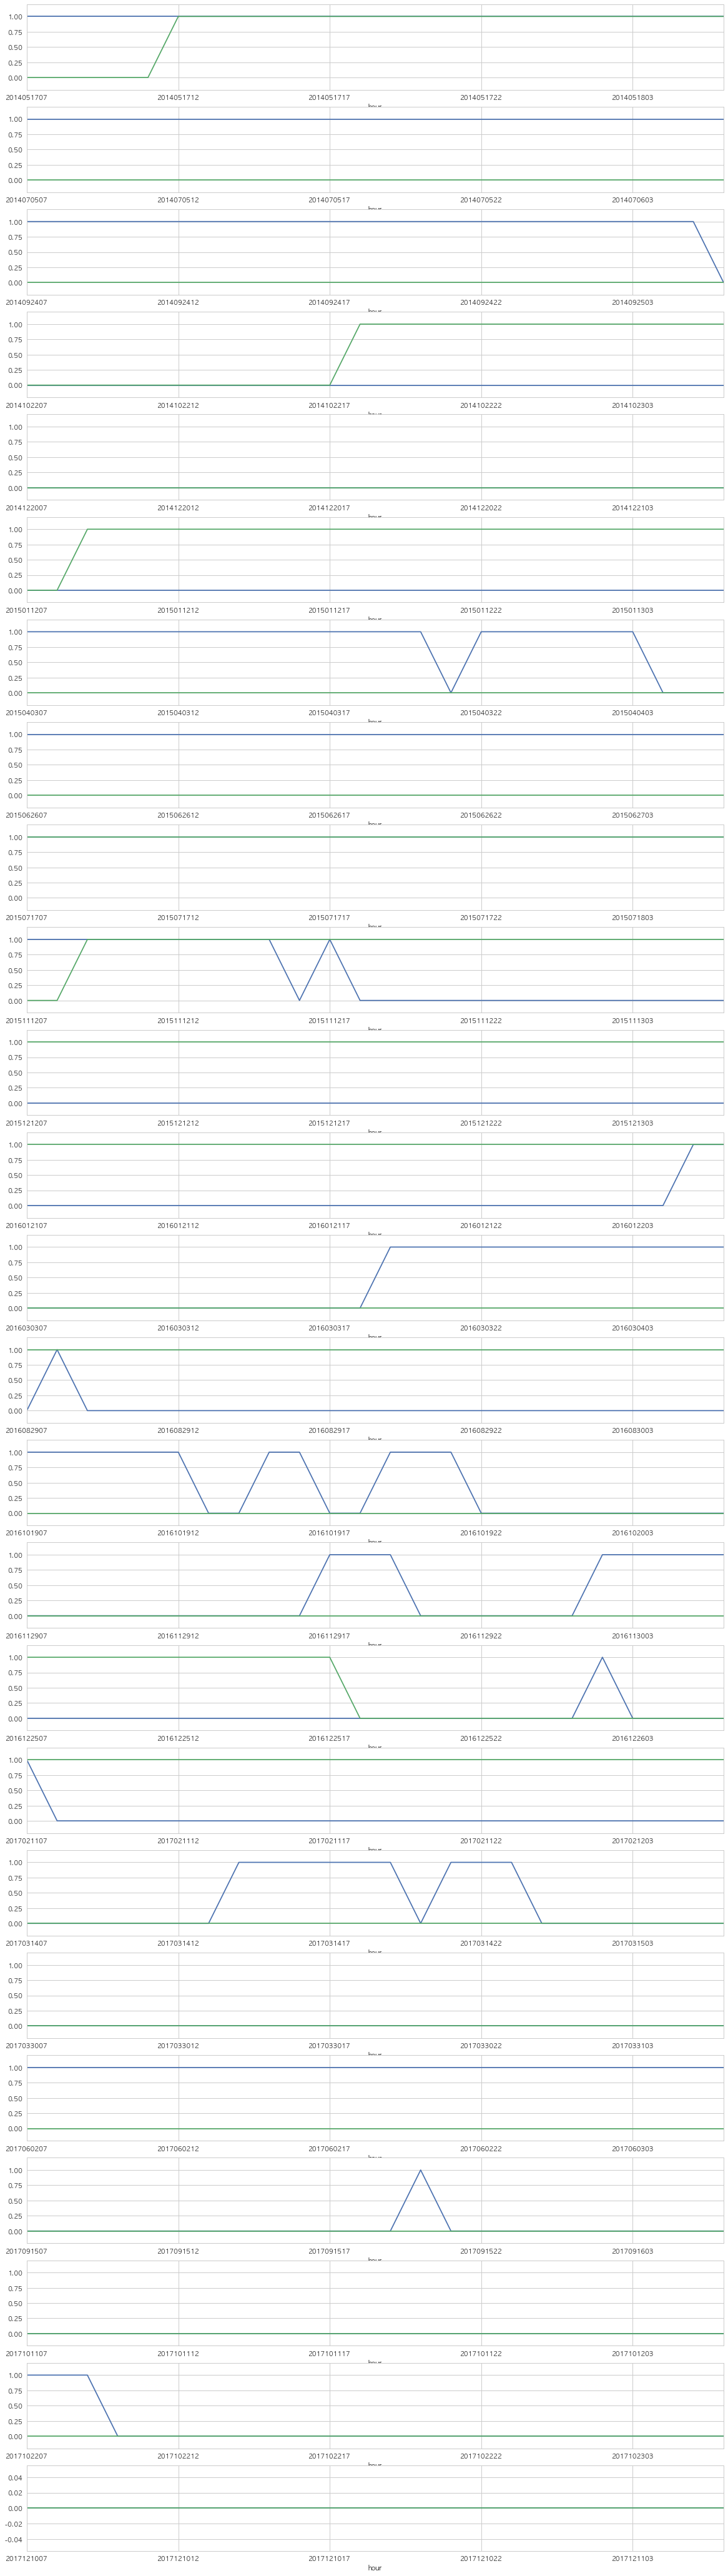

In [64]:
index = 0
for i in range(25):
    index = i*24
    plt.ylim(ymax=1.2,ymin=-0.2)
    plt.subplot(25,1,i+1)
    test_df.iloc[index:index+24]['pred_swell'].plot()
    #test.iloc[index:index+24]['eval_swell'].plot()
    #test_df.iloc[index:index+24]['cls_proba'].plot()
    test_df.iloc[index:index+24]['real_swell'].apply(lambda x:1 if x==2 else 0).plot()

In [65]:
eval_metric = evaluation(df['swell(t+1)'].apply(lambda x: 1 if x == 2 else 0))
#eval_metric = evaluation(df['swell'].fillna(method='ffill'))

In [66]:
scores = []
for day in range(25):
    st = day*24
    print(st)
    scores.append(eval_metric.evaluate(test_df['pred_swell'].iloc[st:st + 24]))
    #print(test['pred_swell'][st:st+24].value_counts())

print(scores)

0
 2    18
 0     3
-1     3
dtype: int64
24
-1    24
dtype: int64
48
-1    23
 1     1
dtype: int64
72
-2    12
 1    12
dtype: int64
96
1    24
dtype: int64
120
-2    21
 1     3
dtype: int64
144
-1    20
 1     4
dtype: int64
168
-1    24
dtype: int64
192
2    23
0     1
dtype: int64
216
-2    10
 2     8
 0     5
 1     1
dtype: int64
240
-2    23
 1     1
dtype: int64
264
-2    20
 0     3
 2     1
dtype: int64
288
 1    12
-1    12
dtype: int64
312
-2    19
 0     3
 1     1
 2     1
dtype: int64
336
 1    13
-1    11
dtype: int64
360
 1    16
-1     8
dtype: int64
384
 1    12
-2    11
-1     1
dtype: int64
408
-2    20
 0     2
 1     1
 2     1
dtype: int64
432
 1    15
-1     9
dtype: int64
456
1    24
dtype: int64
480
-1    24
dtype: int64
504
 1    23
-1     1
dtype: int64
528
1    24
dtype: int64
552
 1    21
-1     3
dtype: int64
576
1    24
dtype: int64
[33, -24, -22, -12, 24, -39, -16, -24, 46, -3, -45, -38, 0, -35, 2, 8, -11, -37, 6, 24, -24, 22, 24, 18, 24]


In [67]:
np.sum(scores)

-99

In [68]:
imp_features

[['22106_습도(%)',
  '22106_습도(%)(t-1)',
  '22106_습도(%)(t-2)',
  '22106_습도(%)(t-3)',
  '22106_유의파고(m)(t-5)',
  '22106_습도(%)(t-5)',
  '22106_습도(%)(t-4)',
  '22106_평균파고(m)(t-4)',
  '22106_평균파고(m)(t-3)',
  '22106_유의파고(m)(t-4)'],
 ['22106_파주기(sec)(t-3)',
  '22106_파주기(sec)(t-4)',
  '22106_파주기(sec)(t-2)',
  '22106_파주기(sec)(t-1)',
  '22453_파주기(sec)(t-5)',
  '22106_습도(%)',
  '22106_습도(%)(t-1)',
  '22106_파주기(sec)',
  '22453_파주기(sec)(t-4)',
  '22453_파주기(sec)(t-3)'],
 ['22106_파주기(sec)(t-3)',
  '22106_파주기(sec)(t-2)',
  '22106_파주기(sec)(t-4)',
  '22106_파주기(sec)',
  '22106_습도(%)(t-1)',
  '22106_습도(%)',
  '22106_파주기(sec)(t-1)',
  '22453_파주기(sec)(t-3)',
  '21229_파주기(sec)(t-4)',
  '22453_파주기(sec)(t-5)'],
 ['22106_파주기(sec)(t-1)',
  '22106_파주기(sec)(t-3)',
  '22106_파주기(sec)(t-2)',
  '22106_파주기(sec)(t-4)',
  '22106_습도(%)(t-2)',
  '22106_파주기(sec)',
  '22106_습도(%)',
  '22106_습도(%)(t-1)',
  '22106_습도(%)(t-3)',
  '22106_파주기(sec)(t-5)'],
 ['22106_습도(%)',
  '22106_습도(%)(t-1)',
  '22106_습도(%)(t-3)',
  '22106_습도(%)(t

### parameter

| index | n_estimators | fl_score | acc |class2_f1_score| class2_acc | eval_score | detail|
| --- | --- | --- |--- |--- |--- |
|1 | 10 | 89 | 89|93|82|706| [21, 24, 24, 33, 24, 40, 24, 24, 38, 34, 39, 40, 24, 44, 24, 20, 31, 32, 22, 24, 24, 24, 24, 24, 24]|
|2|30|92|92|95.7|89|745|[30, 24, 24, 32, 24, 40, 24, 24, 44, 38, 42, 46, 24, 46, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]|
|3|30|92|92|95.3|88.4|738|[32, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 44, 24, 44, 24, 20, 34, 36, 22, 24, 24, 24, 24, 24, 24]
|4|30|93|93|95.2|88.4|737|[30, 24, 24, 32, 24, 42, 24, 24, 42, 36, 41, 46, 24, 44, 24, 20, 34, 38, 20, 24, 24, 24, 24, 24, 24]
|5|50|92|92|95.0|86.9|730|[23, 24, 24, 29, 24, 40, 24, 24, 42, 36, 43, 46, 24, 44, 24, 22, 31, 38, 24, 24, 24, 24, 24, 24, 24]
|6|50|91.8|91.8|95.3|88.4|735|[27, 24, 24, 31, 24, 40, 24, 24, 42, 40, 41, 44, 24, 44, 24, 20, 32, 38, 24, 24, 24, 24, 24, 24, 24]
|7|50|93|93|96|90|744|[33, 24, 24, 33, 24, 42, 24, 24, 40, 36, 43, 46, 24, 44, 24, 22, 33, 38, 22, 24, 24, 24, 24, 24, 24]
|8|100|93|93|95.7|89.3|744|[26, 24, 24, 33, 24, 40, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 38, 24, 24, 24, 24, 24, 24, 24]
|9|100|93|93|96.8|91.7|750|[29, 24, 24, 33, 24, 42, 24, 24, 44, 36, 46, 46, 24, 44, 24, 22, 34, 38, 24, 24, 24, 24, 24, 24, 24]
|10|100|94|93.9|96.5|92.2|752|[35, 24, 24, 33, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 33, 38, 20, 24, 24, 24, 24, 24, 24]
|11|150|93|93|95.8|90.3|745|[32, 24, 24, 33, 24, 42, 24, 24, 44, 40, 43, 46, 24, 44, 24, 20, 33, 34, 22, 24, 24, 24, 24, 24, 24]
|12|150|93.6|93.6|96.7|91.3|753|[35, 24, 24, 31, 24, 42, 24, 24, 42, 40, 45, 46, 24, 44, 24, 22, 34, 36, 24, 24, 24, 24, 24, 24, 24]|
|13|150|93.8|93.8|96.5|91.3|754|[36, 24, 24, 33, 24, 42, 24, 24, 42, 40, 41, 46, 24, 44, 24, 22, 34, 40, 22, 24, 24, 24, 24, 24, 24]
|14|200|92.6|92.6|95.5|88.8|736|[28, 24, 24, 33, 24, 40, 24, 24, 44, 36, 43, 46, 24, 44, 24, 20, 34, 34, 22, 24, 24, 24, 24, 24, 24]
|15|200|94|94|96.8|92.2|756|[35, 24, 24, 33, 24, 42, 24, 24, 44, 40, 45, 46, 24, 44, 24, 22, 33, 36, 24, 24, 24, 24, 24, 24, 24]
|16|200|92.8|92.8|95.7|89.3|741|[34, 24, 24, 33, 24, 40, 24, 24, 44, 40, 41, 46, 24, 44, 24, 22, 33, 30, 22, 24, 24, 24, 24, 24, 24]